Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

# Building a Knowledge Graph Application on Amazon Neptune

This notebook shows how to use Amazon Neptune and Gremlin to construct a knowledge graph for a search solution based on semi-structured data from the [Amazon Web Services Database Blog for Amazon Neptune](https://aws.amazon.com/blogs/database/category/database/amazon-neptune/).
  
  - [Background](#Background)
  - [Getting Started](#Getting-Started)
  - [Stitching Entities Together](#Stitching-Entities-Together)
  - [Finding Unknown Connections](#Finding-Unknown-Connections)
  - [Providing Contextually Relevant Answers](#Providing-Contextually-Relevant-Answers)
  - [Building a Knowledge Graph Solution](#Building-a-Knowledge-Graph-Solution)
  - [Conclusion](#Conclusion)
  - [What's Next?](#What's-Next?)
  
## Background

Modern knowledge graphs are the result of connections of data from multiple different sources.  These sources can either be multiple different databases, different data silos, or data extracted from within entities stored in one or more of these options.  Knowledge graphs come in many different forms but the unifying aspect of them is that they organize data using the entities and connections (known as semantics) familiar to a particular domain.  It represents these semantics as definitions of concepts, their properties, relations between them, and the expected logical constraints. Logic built into such a model allows us to infer understanding and connections about the information contained within the model.

Knowledge graphs consolidate and integrate an organization's information assets and make them more readily available to all members of the organization. There are many applications and use cases that are enabled by knowledge graphs. Information from disparate data sources can be linked and made accessible to answer questions you may not even have thought of yet. Information and entities can be extracted not only from structured sources (e.g., relational databases) but also from semi-structured sources (e.g., media metadata, spreadsheets) and unstructured sources (e.g., text documents, email, news articles).

The examples in this use case show how we can use our blog knowledge graph to demonstrate how we can use the connected nature of our knowledge graph to provide contextually relevant answers to search questions.

## Getting Started

In this section we'll load the knowledge graph and set some visualization options. We'll then use some Gremlin queries to inspect the data model used throughout the solution.

### Load data

The cell below loads the example knowledge graph into your Neptune cluster. When you run the cell it will automatically install the `knowledge-graph` dataset into your graph which takes a few minutes.

In [ ]:
%seed --model Property_Graph --dataset knowledge-graph --run

### Set visualization options

The command below configures the visualization to use specific colours and icons for the different parts of the data model.

In [ ]:
%%graph_notebook_vis_options

{
  "groups": {
    "post": {
      "shape": "icon",
      "icon": {
        "face": "FontAwesome",
        "code": "\uf15b",
        "color": "red"
      }
    },
    "author": {
      "shape": "icon",
      "icon": {
        "face": "FontAwesome",
        "code": "\uf007",
        "color": "orange"
      }
    },
    "tag": {
      "shape": "icon",
      "icon": {
        "face": "FontAwesome",
        "code": "\uf02b",
        "color": "green"
      }
    },
    "date": {
      "shape": "icon",
      "icon": {
        "face": "FontAwesome",
        "code": "\uf073",
        "color": "blue"
      }
    },
    "other": {
      "shape": "icon",
      "icon": {
        "face": "FontAwesome",
        "code": "\uf074",
        "color": "blue"
      }
    },
    "organization": {
      "shape": "icon",
      "icon": {
        "face": "FontAwesome",
        "code": "\uf1ad",
        "color": "blue"
      }
    },
    "location": {
      "shape": "icon",
      "icon": {
        "face": "FontAwesome",
        "code": "\uf276",
        "color": "blue"
      }
    },
    "title": {
      "shape": "icon",
      "icon": {
        "face": "FontAwesome",
        "code": "\uf1dc",
        "color": "blue"
      }
    },
    "commercial_item": {
      "shape": "icon",
      "icon": {
        "face": "FontAwesome",
        "code": "\uf1b3",
        "color": "blue"
      }
    }
  },
  "edges": {
    "color": {
      "inherit": false
    },
    "smooth": {
      "enabled": true,
      "type": "straightCross"
    },
    "arrows": {
      "to": {
        "enabled": false,
        "type": "arrow"
      }
    },
    "font": {
      "face": "courier new"
    }
  },
  "interaction": {
    "hover": true,
    "hoverConnectedEdges": true,
    "selectConnectedEdges": false
  },
  "physics": {
    "minVelocity": 0.75,
    "barnesHut": {
      "centralGravity": 0.1,
      "gravitationalConstant": -50450,
      "springLength": 200,
      "springConstant": 0.04,
      "damping": 0.09,
      "avoidOverlap": 0.1
    },
    "solver": "barnesHut",
    "enabled": true,
    "adaptiveTimestep": true,
    "stabilization": {
      "enabled": true,
      "iterations": 1
    }
  }
}

### Data model

The knowledge graph used in our example is constructed from data extracted from the [Amazon Web Services Database Blog](https://aws.amazon.com/blogs/database/category/database/amazon-neptune/) for Amazon Neptune.  From this information, we'll create two categories of entities: structured entities and extracted entities.

#### Structured Entities

In many companies the a large proportion of the knowledge of the company is stored in semi-structured or unstructured documents such as emails, word documents, chat transcripts, or other web pages.  Knowledge graphs have the unique capability to connect this information together in a contextually relevant manner to provide critical insights into those connections.  Linking relevant pieces of data together enables systems that can recommend people to projects, connect related projects, or centralize access to avoid duplicate efforts. 

In this example the semi-structured data created from the Amazon Web Services Databases blog provides the backbone of the knowledge graph structure and consists of information such as the `post`, `author`(s), and associated `tag`(s).

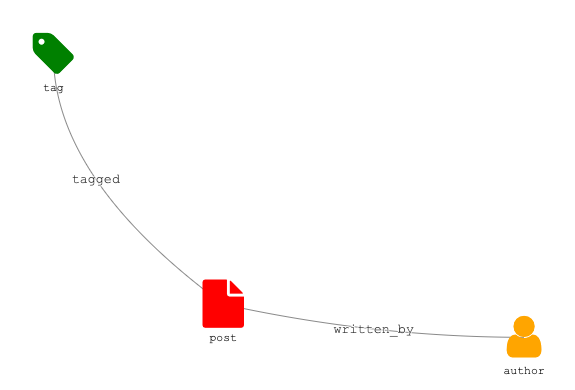

#### Extracted Entities
The second type of entity in this knowledge graph are extracted from the original entities and provide additional context and connections within our knowledge graph.  When building knowledge graphs a common practice is to augment the structured components of your data by extracting keywords and concepts from text-heavy content such as emails, word documents, PDF, and spreadsheets or meta-data from video, audio, and photos to build a knowledge graph. Augmenting a knowledge graph of structured data with additional relationships extracted from the data in those entities enables a comprehensive view of the domain being modeled.

For this example the Natural Language Processing capabilities of [Amazon Comprehend](https://aws.amazon.com/comprehend/) were used to identify important entities within the blog text such as titles, dates, organizations, and items.  These entities and connections were then used to augment our graph as shown below.

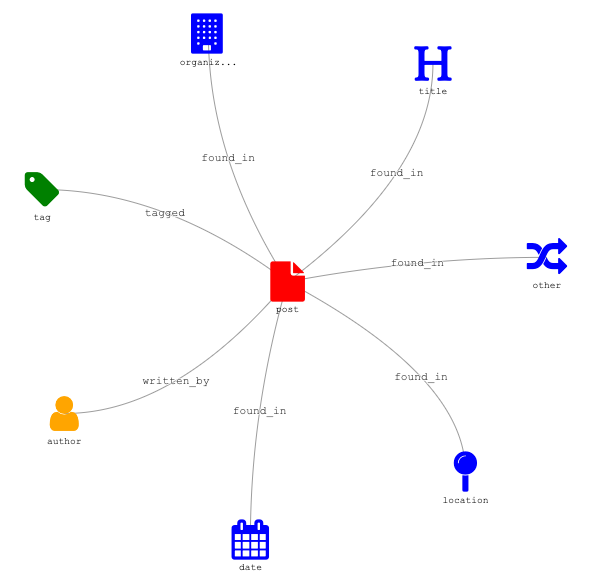

The following query shows a single post and its associated features. After running the query, click the `Graph` tab to see a visualization of the results. Note that the blog post below contains the following structural entities:

* 1 `post` vertex
* 3 `author` vertices
* 1 `tag` vertex

In addition to these structural entities this single post contains the following extracted entities:

* 3 `title` vertices
* 2 `organization` vertices
* 2 `date` vertices
* 1 `location` vertex

In [ ]:
%%gremlin -p v,outE,inV

g.V('https://aws.amazon.com/blogs/database/how-to-get-started-with-neptune-ml/').
  outE().inV().path().by(valueMap().with(WithOptions.tokens))

While seeing the connected nature of the structured and extracted entities within a single query is interesting the real power of a knowledge graph comes from seeing how these items are connected together.  

The next query shows all the posts that share the same author as the original post. In this case, the authors have written a total of 9 blog posts. After running the query, click the `Graph` tab to see a visualization of the results.

In [ ]:
%%gremlin  -p V,outE,inV,inE,outV

g.V('https://aws.amazon.com/blogs/database/how-to-get-started-with-neptune-ml/').
  outE('written_by').
  inV().hasLabel('author').
  inE('written_by').outV().
  path().by(valueMap().with(WithOptions.tokens))

From this sort of query we can begin to see how knowledge graphs begin to enable seeing connections within our data.  If we run this same query starting at a different post we see how this can also show that the authors have collaborated on multiple posts.  After running the query, click the Graph tab to see a visualization of the results.

In [ ]:
%%gremlin -p V,outE,inV,inE,outV
g.V(
  'https://aws.amazon.com/blogs/database/let-me-graph-that-for-you-part-1-air-routes/').
  outE('written_by').
  inV().hasLabel('author').
  inE('written_by').outV().
  path().by(valueMap().with(WithOptions.tokens))

## Stitching Entities Together

Another powerful use case for a knowledge graph is to answer questions that require connecting entities together to provide meaning to the answer. Let's examine the following question:

### What is the most common topic author X writes about?

If we only used the structured data to answer this question, then we would only be able to determine the answer to this using the relatively limited set of tags provided on the blog. The knowledge graph we built allows us to leverage relationships to extracted entities as well to provide additional contextual information based on the text of the blog.  The following query shows a list of the most popular extracted phrases and the number of times each of them has appeared in relation to the author `Dave Bechberger`.

In [ ]:
%%gremlin -p v,in,out

g.V('Dave Bechberger').
  in('written_by').
    out('found_in').groupCount().by('text').order(local).
    by(values, Order.decr).unfold()

As we see, `AWS` and `Amazon` are the most commonly written about topics with `Neptune` coming in third place.  However this question really only scratches the surface of the types of contextual questions that a knowledge graph is able to answer.  Instead of just finding out information about a specific author what if we wanted to answer a question about Dave Bechberger's co-authors work?

### What is the most common topic co-authors of author X write about?

This question extends the scope of our previous work by stitching together not only the extracted entities (`organization`, `title`, `date`, `commercial_item`, `other`) of our data but also the structured entities (`author`, `post`, `tag`) as well.  Combining these two different categories of elements together shows how we can help stitch contextual answers to complex questions from our knowledge graph as seen here:

In [ ]:
%%gremlin

g.V('Dave Bechberger').as('a').
  in('written_by').
  out('written_by').
  where(neq('a')).
  in('written_by').
  out('found_in').
  groupCount().by('text').
  order(local).by(values, Order.decr).
  unfold()

As with the last query, `AWS`, `Amazon`, and `Neptune` also top the list here.  By further modifying the query above to remove the Amazon specific topics we can find the most commonly written about topics.

### What is the most common (non-Amazon) topic?

Run the following query and view the results.

In [ ]:
%%gremlin 

g.V().hasLabel('author').
  in('written_by').
  out('found_in').
  has('text', without('AWS', 'Amazon', 'Neptune')).
  groupCount().by('text').
  order(local).by(values, Order.decr).
  unfold()

As we can see, `Comprehend` is by far the most commonly referenced topic in the blog with Python and Seattle in a close race for second. To take it a step further, what if you are also interested in how the above results relate to each other visually in a graph? Run the query below, and then click the Graph tab to see a visualization of how these topics are connected.

In [ ]:
%%gremlin -g type -p v,inE,outV,outE,inV

g.V().hasLabel('author').
  inE('written_by').outV().
  outE('found_in').inV().
  has('text', without('AWS', 'Amazon', 'Neptune')).
  path().by(
      valueMap().with(WithOptions.tokens)
  )

From the visualization above, we can start to see that most of our data is highly connected with only a handful of outliers that have few to no connections. With this overview of our graph data, let's take a look at another common use for knowledge graphs: finding unknown connections between entities.
## Finding Unknown Connections
One of the advantages of using a knowledge graph for answering search questions is that the entities, in this case blog posts, share features with other posts. This allows for discovery of connections between data that are sometimes not obvious.

### Find the connections between China and Ohio
    
Unlike the post-centric or author-centric graph local interactive queries in this notebook so far, this is more of an analytics query, which starts at a specific extracted entity. In this query, we start at the `location` of `China`, and continue moving through the connections in the graph until an end condition is met: the `location` of `Ohio`.

The results here show how there can be multiple paths connecting these two seemingly unrelated entities together. Run the query below, and then click the Graph tab to see a visualization of how these topics are connected.


In [ ]:
%%gremlin

g.V().
  has('location', 'text', 'China').as('l').
  repeat(
    in('found_in').out('found_in').hasLabel('location').simplePath()).
    until(has('location', 'text', 'Ohio')).
  path().by(
      valueMap().with(WithOptions.tokens)
  )

We can add additional filtering properties into this sort of query to provide a more focused set of connections between `China` and `Ohio`.  In the query below we have modified our last query to remove any connections through `Wellington`.  

In [ ]:
%%gremlin

g.V().
  has('location', 'text', 'China').as('l').
  repeat(
    in('found_in').out('found_in').has('location', 'text', without('Wellington')).simplePath()).
    until(has('location', 'text', 'Ohio')).
  path().by(
      valueMap().with(WithOptions.tokens)
  )

Examining the previous two results we see that the addition of the filtering criteria has narrowed our results by removing any connections through `Wellington`.


## Providing Contextually Relevant Answers

Combining all the concepts we have demonstrated so far, we begin to provide contextually relevant answers to questions about how the data elements relate to each other. These sorts of questions are common in many user interactions such as question and answer applications, chatbots, or search engines.

Let's take a look at the following example:

### Find me how Dave Bechberger is connected to posts that mention Seattle 


This query might seem a bit complicated at first but this is exactly the type of question that a knowledge graph enables us to answer in a quick and efficent manner.  Run the query below, then click the `Graph` tab to see a visualization of the answer to our question.


In [ ]:
%%gremlin
g.V('Dave Bechberger').as('a').
  in('written_by').
  out('written_by').
  where(neq('a')).
  in('written_by').
  out('found_in').
  has('location', 'text', 'Seattle').
  repeat(
    in('found_in').
    simplePath().
    out('found_in').
    simplePath().
    hasLabel('location')).
    until(has('location', 'text', 'Wellington')).
  path().by(
      valueMap().with(WithOptions.tokens)
  )

## Building a Knowledge Graph Solution
A knowledge graph is but one building block in a more complete knowledge management solution. Knowledge graphs are rarely used in isolation and knowledge graphs in Neptune are no exception. Constructing and maintaining large-scale high-quality knowledge graph applications requires integration across multiple sources, both on the front-end and backend, to develop an effective solution.
### Knowledge enhanced applications
Knowledge graphs are at the core of many human-facing applications such as search systems, as demonstrated in this notebook, but also question and answering bots, recommendation systems, chatbots, and other highly interactive interfaces. Each of these applications puts a unique set of requirements and scenarios on the application where the connected nature of data in a knowledge graph provides a robust mechanism for quickly and efficiently providing answers.
### Knowledge graphs and machine learning
Knowledge graphs and machine learning are a natural complement in many applications. The connected nature of data in a knowledge graph is capable of providing unique and novel insight to machine learning applications. In turn, the output of many machine learning tasks can also be stored back into a knowledge graph to enrich the connections within the graph and enable it to better service user applications.
### Knowledge graph architectures
The following diagram shows how Neptune can be used with other Amazon Web services to build knowledge solutions. You can load data directly into Neptune using query APIs, or from relational databases using the Amazon Web Services Database Migration Service. Neptune also supports bulk loading data from Amazon S3. Neptune can be deployed in conjunction with Amazon SageMaker to train predictive models or Amazon Comprehend to extract additional entities from within the knowledge graph data. Finally, Neptune can then be leveraged to support a wide array of end user applications.


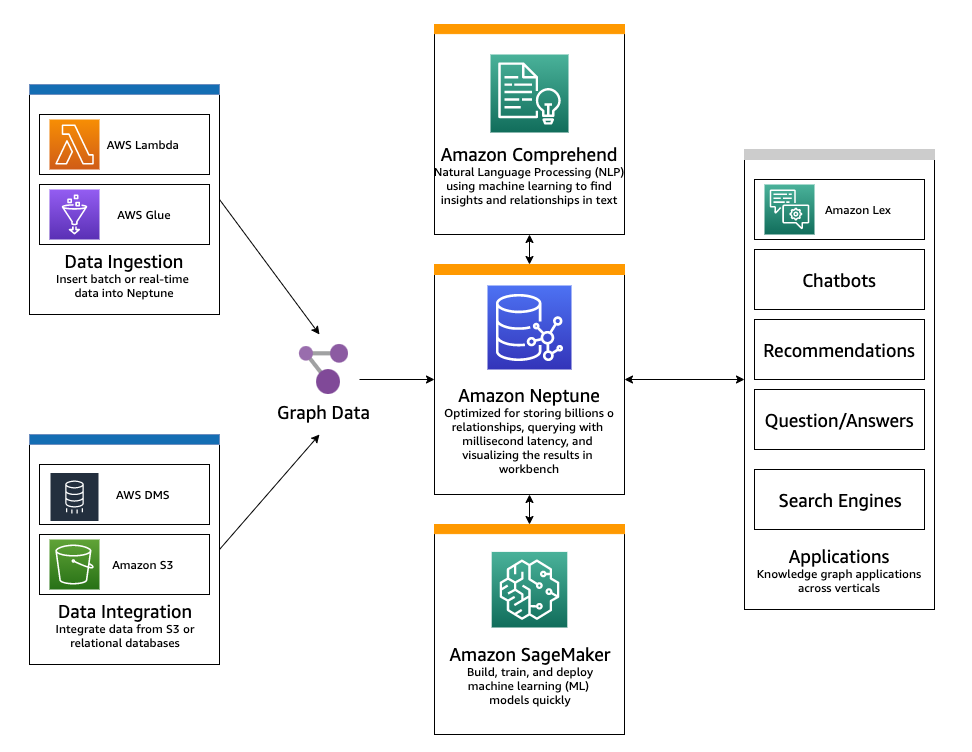

## Conclusion

This notebook has shown how you can use Amazon Neptune to create a knowledge graph as part of a bigger contextual search solution. We've used a blog post dataset with post-centric and author-centric queries to do the following:
1.	Find and stitch data entities together
2.	Find unknown connections between them
3.	Use these stitched and unknown connections to provide contextually relevant answers to real world search questions

Real-world data is tangled, messy and disconnected. We've suggested a knowledge graph data model and queries that can help provide better and more complete answers through the use of contextually connected graph data. This type of solution can be used to power many kinds of applications such as question/answer bots, real time chatbots, or web-based search engines.

## What's Next?

The examples in this notebook show how to develop a knowledge graph data model and accompanying queries. To build a knowledge graph solution that incorporates Neptune, we recommend the following resources:

  - [Getting Started with Amazon Neptune](https://pages.awscloud.com/AWS-Learning-Path-Getting-Started-with-Amazon-Neptune_2020_LP_0009-DAT.html) is a video-based learning path that shows you how to create and connect to a Neptune database, choose a data model and query language, author and tune graph queries, and integrate Neptune with other Amazon Web services.
  - Before you begin designing your database, consult the [Amazon Web Services Reference Architectures for Using Graph Databases](https://github.com/aws-samples/aws-dbs-refarch-graph/) GitHub repo, where you can browse examples of reference deployment architectures, and learn more about building a graph data model and choosing a query language.
  - For links to documentation, blog posts, videos, and code repositories with samples and tools, see the [Amazon Neptune developer resources](https://aws.amazon.com/neptune/developer-resources/).
  - Neptune ML makes it possible to build and train useful machine learning models on large graphs in hours instead of weeks. To find out how to set up and use a graph neural network, see [Using Amazon Neptune ML for machine learning on graphs](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning.html).
  